In [1]:
root = "/home/shi/WorkSpace/projects/scMultiNet_Data/"

loc1 = root + "/Step_6_data/avg_attention_x_gene_expression.csv"

raw_data_loc = root + "/Step_1_data/Dataset_cook//TrVal_dataset_PC_TGFb_GTlabel5.pkl"
code_loc = "/home/shi/WorkSpace/projects/scMultiNet_workspace/"
vocab_loc = code_loc + "/Experiment/support_data/vocab_16k.json" 

In [2]:
# 把scLLM的位置添加进system path保证可以import scLLM
import sys

sys.path.append(code_loc)
# 数据集读取
import dill
# 用dill打开loc0的pkl 文件读取dataset
with open(raw_data_loc,"rb") as f:
    [trainset,valset,_,label_dict] = dill.load(f)
# 输出数据集信息
print("trainset size: ",len(trainset))
print("valset size: ",len(valset)) if valset is not None else print("no valset")
print(label_dict)

trainset size:  5881
valset size:  1471
{'3d': 0, '7d': 1, '1d': 2, '8h': 3, '0d': 4}


In [3]:
# vocab 读取
import json
with open(vocab_loc,"r") as f:
    vocab = json.load(f)


# 根据字典的值进行排序，并获取排序后的键
sorted_genes = sorted(vocab, key=vocab.get)

# 现在 sorted_genes 是一个按值排序的基因名称列表
sorted_genes.append("CLS")
print(sorted_genes[:20])
print(len(sorted_genes))

['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AAR2', 'AARS2', 'AARSD1', 'AASDH']
16907


In [4]:
import pandas as pd
df = pd.read_csv(loc1)
# change Unnamed: 0 to gene_names
df = df.rename(columns={"Unnamed: 0":"gene_names"})
df = df.set_index("gene_names")
df

,3d,7d,1d,8h,0d
gene_names,,,,,
A1BG,0.062998,0.005782,0.088079,0.164279,0.325546
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,0.000000,0.000000,0.000000,0.000000,0.000000
A2ML1,0.000000,0.000000,0.000000,0.000000,0.000000
A4GALT,0.003037,0.003711,0.015328,0.005511,0.101230
...,...,...,...,...,...
ZYG11B,0.026219,0.040605,0.029256,0.041918,0.152245
ZYX,0.504995,0.547233,0.997993,0.746664,1.033372
ZZEF1,0.014213,0.003596,0.049101,0.035431,0.157280


In [5]:
# 为每个列计算gene_names的排序
gene_rankings = {col: df[col].sort_values(ascending=False).index.tolist() for col in df.columns}

gene_rankings.keys()  # 显示所有列的名字以验证步骤

dict_keys(['3d', '7d', '1d', '8h', '0d'])

In [7]:
import pandas as pd 

df = pd.DataFrame(gene_rankings)

df.to_csv(root + "/Step_6_data/avg_weight_features_ranking.csv")

In [6]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import zscore

# 假设X, vocab, gene_rankings, labels已经定义
X = trainset.data
labels = trainset.label
# 将稀疏矩阵X转换为密集矩阵并标准化（计算Z-score）
# 假设X已经是一个密集矩阵了
X_dense = np.array(X.todense())  # 确保这是一个numpy数组

# 计算均值和标准差
mean_X = np.mean(X_dense, axis=0, keepdims=True)
std_X = np.std(X_dense, axis=0, ddof=1, keepdims=True)  # ddof=1用于样本标准差

# 计算Z-score
X_zscore = (X_dense - mean_X) / std_X
# set nan to 0 in X_zscore
X_zscore[np.isnan(X_zscore)] = 0



/tmp/ipykernel_3788/782512003.py:17: RuntimeWarning: invalid value encountered in divide
  X_zscore = (X_dense - mean_X) / std_X


In [7]:
reverse_label_dict = {v:k for k,v in label_dict.items()}
label_names = [reverse_label_dict[int(labels[i])] for i in range(labels.shape[0])]
np_label_names = np.array(label_names)

In [8]:
# 初始化一个字典来保存每个类别的平均Z-score
avg_zscores = {}
gene_nb= 10
# 对于gene_rankings中的每个类别
all_gene_indices = []
all_gene_names = []
all_gene_cat = []
sample_idxs = {}
for cat in["0d","8h","1d","3d","7d"]:
    category = cat
    genes = gene_rankings[category]
    # 获取前gene_nb个基因的索引
    gene_indices = [vocab[gene] for gene in genes[:gene_nb] if gene in vocab]
    gene_names= [gene for gene in genes[:gene_nb] if gene in vocab]
    gene_cat = [category for gene in genes[:gene_nb] if gene in vocab]
    # 获取对应这个类别的样本的索引
    category_indices = np.where(np_label_names == category)[0]
    # 类别索引单独保存
    sample_idxs.update({category:category_indices})
    # 将这些索引添加到all_gene_indices和all_gene_names中
    all_gene_indices = all_gene_indices + gene_indices
    all_gene_names = all_gene_names + gene_names
    all_gene_cat = all_gene_cat + gene_cat
    
for cat in["0d","8h","1d","3d","7d"]:
    category_indices = sample_idxs[cat]
    for gene_idx,gene_name in zip(all_gene_indices,all_gene_names):
        gene_avg_zscore = np.mean(X_zscore[category_indices, gene_idx])
        if cat in avg_zscores:
            avg_zscores[cat].append({gene_name:gene_avg_zscore})
        else:
            avg_zscores[cat] = [{gene_name:gene_avg_zscore}]

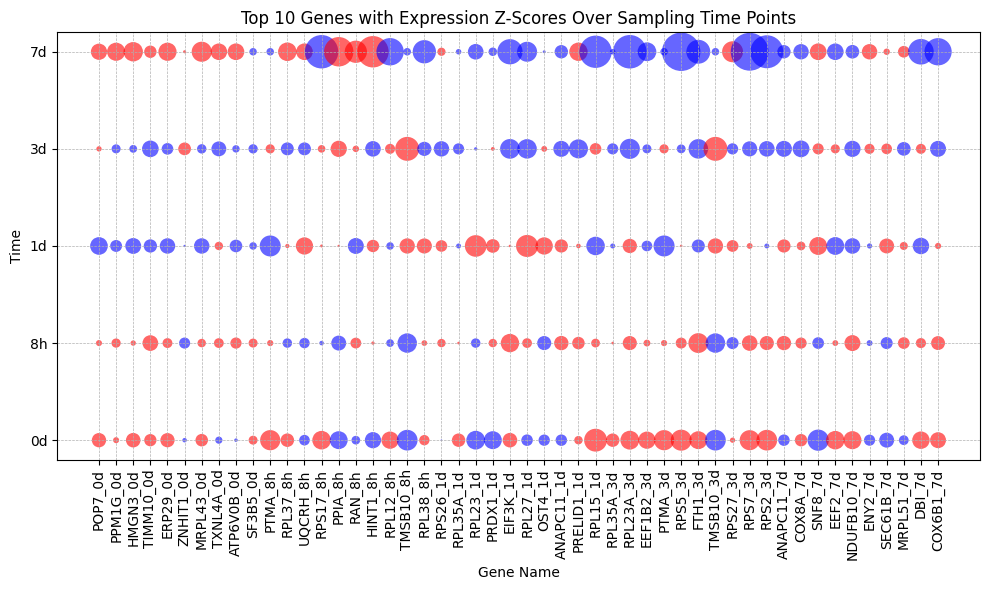

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Prepare data for plotting
genes = all_gene_names
times = ['0d', '8h', '1d', '3d', '7d']
colors = {'pos': 'red', 'neg': 'blue'}

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each gene at each time point
for time_idx, time in enumerate(times):
    for gene_idx, gene in enumerate(genes):
        # Find the score for the gene at the current time
        score = next(item for item in avg_zscores[time] if gene in item)[gene]
        color = colors['pos'] if score > 0 else colors['neg']
        size = np.abs(score) * 1000  # Scale factor for visibility
        ax.scatter(gene_idx, time_idx, s=size, c=color, alpha=0.6, edgecolors='none')

# Set the x-ticks to be the gene names and y-ticks to be the time points
ax.set_xticks(range(len(genes)))
x_label = [n+"_"+c for n,c in zip(all_gene_names,all_gene_cat)]
ax.set_xticklabels(x_label, rotation=90)
ax.set_yticks(range(len(times)))
ax.set_yticklabels(times)

# Add grid, labels, and title for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Gene Name')
plt.ylabel('Time')
plt.title('Top 10 Genes with Expression Z-Scores Over Sampling Time Points')

# Show plot
plt.tight_layout()
plt.show()

In [10]:
# 初始化一个字典来保存每个类别的平均Z-score
avg_zscores = {}
gene_nb= 1000
# 对于gene_rankings中的每个类别
all_gene_indices = []
all_gene_names = []
all_gene_cat = []
sample_idxs = {}
for cat in["0d","8h","1d","3d","7d"]:
    category = cat
    genes = gene_rankings[category]
    # 获取前50个基因的索引
    gene_indices = [vocab[gene] for gene in genes[:gene_nb] if gene in vocab]
    gene_names= [gene for gene in genes[:gene_nb] if gene in vocab]
    gene_cat = [category for gene in genes[:gene_nb] if gene in vocab]
    # 获取对应这个类别的样本的索引
    category_indices = np.where(np_label_names == category)[0]
    # 类别索引单独保存
    sample_idxs.update({category:category_indices})
    # 将这些索引添加到all_gene_indices和all_gene_names中
    all_gene_indices = all_gene_indices + gene_indices
    all_gene_names = all_gene_names + gene_names
    all_gene_cat = all_gene_cat + gene_cat
    
for cat in["0d","8h","1d","3d","7d"]:
    category_indices = sample_idxs[cat]
    for gene_idx,gene_name in zip(all_gene_indices,all_gene_names):
        gene_avg_zscore = np.mean(X_zscore[category_indices, gene_idx])
        if cat in avg_zscores:
            avg_zscores[cat].update({gene_name:gene_avg_zscore})
        else:
            avg_zscores[cat] = {gene_name:gene_avg_zscore}

In [11]:
def plot_dot_in_cat(avg_zscores,target_cat,target_len = 10,scale_factor=1000,root="/home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure/"):
    all_possible_cats = ["0d","8h","1d","3d","7d"]

    avg_zscores[target_cat]
    import matplotlib.pyplot as plt
    import numpy as np


    # 首先从 avg_zscores 中提取所有 0d 基因的平均 Z-score
    imp_gene_idx_mask = np.array(all_gene_cat) == target_cat
    imp_gene_names = np.array(all_gene_names)[imp_gene_idx_mask]
    genes = []
    for key in list(avg_zscores[target_cat].keys()):
        v = avg_zscores[target_cat][key]
        if key in imp_gene_names and len(genes)<target_len:
            genes.append(key)

    new_avg_zscores = {}

    for cat in  ['0d', '8h', '1d', '3d', '7d']:
        new_avg_zscores[cat] = []
        for key in list(avg_zscores[cat].keys()):
            if key in genes:
                new_avg_zscores[cat].append({key:avg_zscores[cat][key]})

    # Prepare data for plotting
    times = ['0d', '8h', '1d', '3d', '7d']
    colors = {'pos': 'red', 'neg': 'blue'}

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(4, 10))

    # Plot each gene at each time point
    for time_idx, time in enumerate(times):
        for gene_idx, gene in enumerate(genes):
            # Find the score for the gene at the current time
            score = next(item for item in new_avg_zscores[time] if gene in item)[gene]
            color = colors['pos'] if score > 0 else colors['neg']
            size = np.abs(score) * scale_factor  # Scale factor for visibility
            ax.scatter(time_idx, gene_idx,  s=size, c=color, alpha=0.6, edgecolors='none')

    # Set the x-ticks to be the gene names and y-ticks to be the time points
    ax.set_yticks(range(len(genes)))
    ax.set_yticklabels(genes)
    ax.set_xticks(range(len(times)))
    ax.set_xticklabels(times)

    # Add grid, labels, and title for clarity
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('time')
    plt.ylabel(f'Top {target_len} Genes in {target_cat}')
    plt.title(f'{target_cat}')

    # Show plot
    plt.tight_layout()
    plt.savefig(root+f"rank1_{target_cat}.pdf")
    plt.show()

In [12]:
target_len = 30

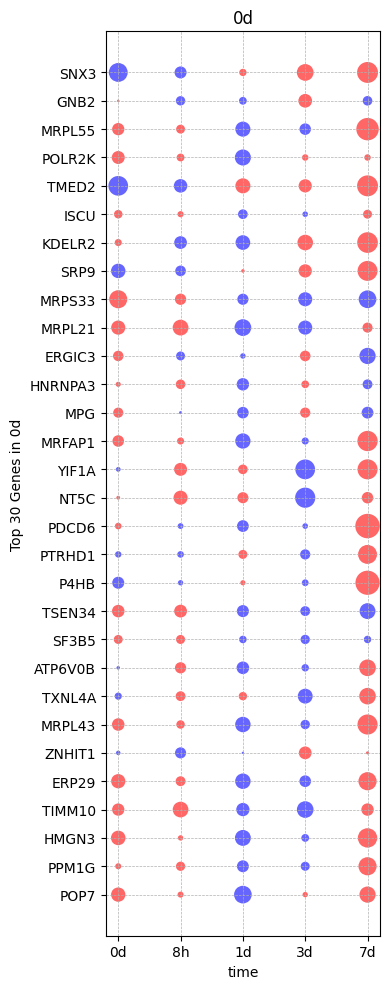

In [13]:
plot_dot_in_cat(avg_zscores,"0d",target_len)

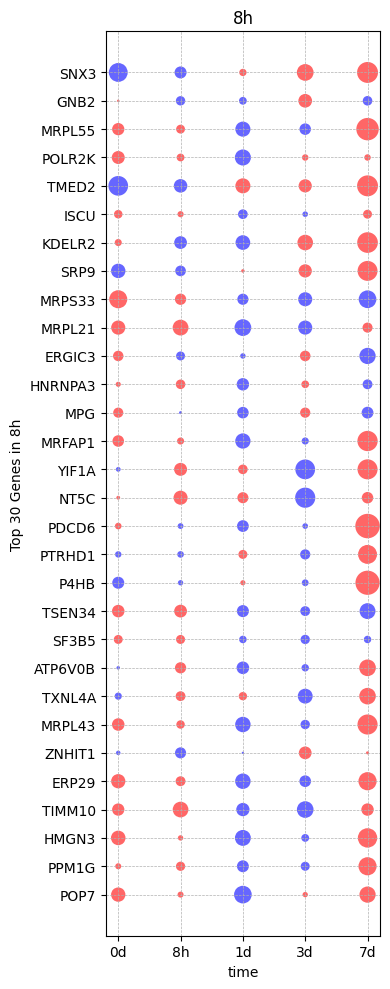

In [14]:
plot_dot_in_cat(avg_zscores,"8h",target_len)

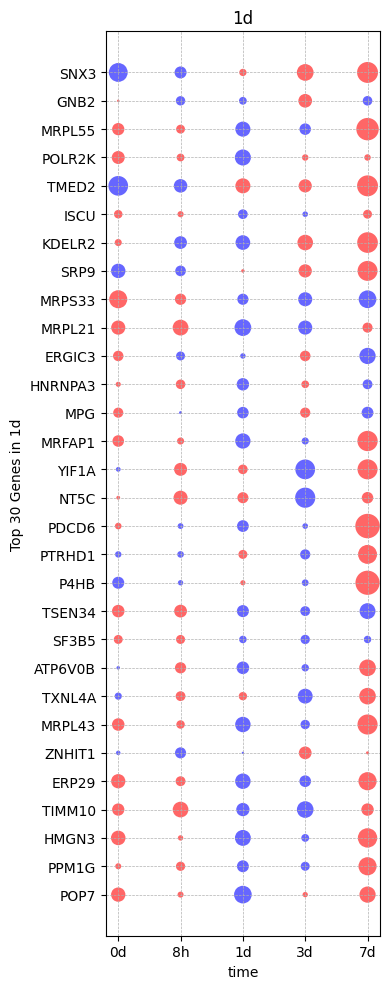

In [15]:
plot_dot_in_cat(avg_zscores,"1d",target_len)

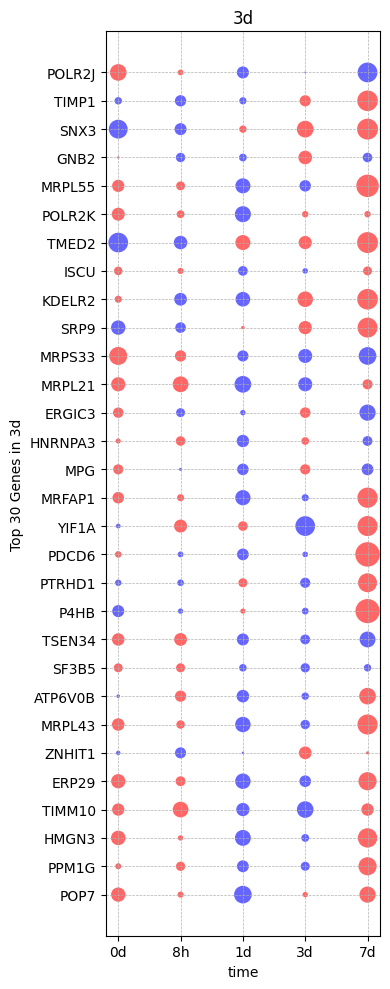

In [16]:
plot_dot_in_cat(avg_zscores,"3d",target_len)

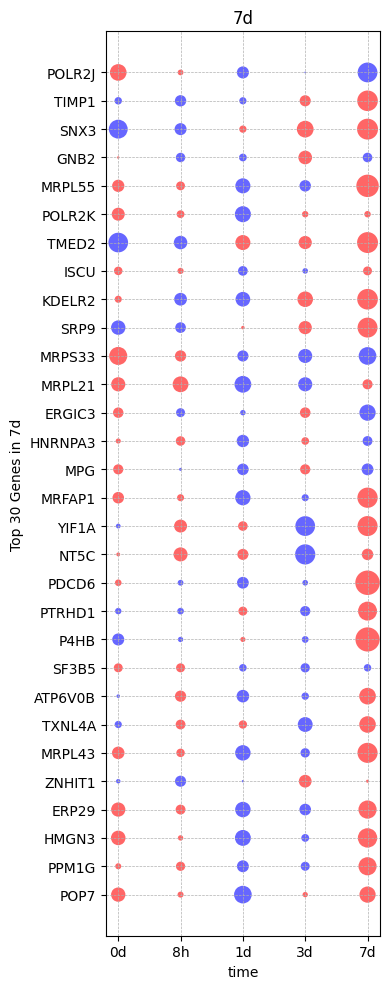

In [17]:
plot_dot_in_cat(avg_zscores,"7d",target_len)

In [18]:
def plot_dot_in_cat_rank2(avg_zscores, target_cat, target_len=10,scale_factor=1000,root="/home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure/"):
    all_possible_cats = ["0d", "8h", "1d", "3d", "7d"]

    # 提取目标类别的所有基因及其平均Z-score
    target_cat_genes_scores = avg_zscores[target_cat]
    
    # 根据平均Z-score进行排序，并获取top 5和bottom 5
    sorted_genes = sorted(target_cat_genes_scores.items(), key=lambda x: x[1], reverse=True)
    top_genes = sorted_genes[:int(target_len/2)]
    bottom_genes = sorted_genes[-int(target_len/2):]
    
    # 合并top 5和bottom 5基因
    selected_genes = top_genes + bottom_genes
    gene_names = [gene[0] for gene in selected_genes]
    
    import matplotlib.pyplot as plt
    import numpy as np

    times = ['0d', '8h', '1d', '3d', '7d']
    colors = {'pos': 'red', 'neg': 'blue'}

    fig, ax = plt.subplots(figsize=(4,10))

    for time_idx, time in enumerate(times):
        for gene_idx, gene_info in enumerate(selected_genes):
            gene_name, _ = gene_info
            score = avg_zscores[time][gene_name]
            color = colors['pos'] if score > 0 else colors['neg']
            size = np.abs(score) * scale_factor  # 调整点的大小以改善可视化效果
            ax.scatter(time_idx, gene_idx, s=size, c=color, alpha=0.6, edgecolors='none')

    ax.set_yticks(range(len(gene_names)))
    ax.set_yticklabels(gene_names)
    ax.set_xticks(range(len(times)))
    ax.set_xticklabels(times)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel(f'Top and Bottom 5 Genes in {target_cat}')
    plt.title(f'Gene Z-Score Distribution Across Time in {target_cat}')

    plt.tight_layout()
    plt.savefig(f"{root}/rank2_{target_cat}.pdf")
    plt.show()


In [ ]:
plot_dot_in_cat_rank2(avg_zscores, "0d", target_len=30,scale_factor=500)

In [ ]:
plot_dot_in_cat_rank2(avg_zscores, "8h", target_len=30,scale_factor=500)

In [ ]:
plot_dot_in_cat_rank2(avg_zscores, "1d", target_len=30,scale_factor=500)

In [ ]:
plot_dot_in_cat_rank2(avg_zscores, "3d", target_len=30,scale_factor=500)

In [ ]:
plot_dot_in_cat_rank2(avg_zscores, "7d", target_len=30,scale_factor=500)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_dot_in_cat_rank2_and_save_csv(avg_zscores, target_cat, target_len=10, scale_factor=1000, root="/home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure/"):
    all_possible_cats = ["0d", "8h", "1d", "3d", "7d"]

    # 提取目标类别的所有基因及其平均Z-score
    target_cat_genes_scores = avg_zscores[target_cat]
    
    # 根据平均Z-score进行排序，并获取top 5和bottom 5
    sorted_genes = sorted(target_cat_genes_scores.items(), key=lambda x: x[1], reverse=True)
    top_genes = sorted_genes[:int(target_len/2)]
    bottom_genes = sorted_genes[-int(target_len/2):]
    
    # 合并top 5和bottom 5基因
    selected_genes = top_genes + bottom_genes
    gene_names = [gene[0] for gene in selected_genes]
    
    # 收集所有类别下选定基因的Z-score
    genes_scores_across_cats = {gene: {cat: avg_zscores[cat].get(gene, 0) for cat in all_possible_cats} for gene, _ in selected_genes}
    
    # 转换为DataFrame
    genes_scores_df = pd.DataFrame(genes_scores_across_cats).T  # 转置以使基因名成为行索引
    genes_scores_df.reset_index(inplace=True)
    genes_scores_df.rename(columns={'index': 'Gene'}, inplace=True)
    # 创建DataFrame
    
    # 保存为CSV文件
    csv_path = f"{root}/{target_cat}_selected_genes.csv"
    genes_scores_df.to_csv(csv_path, index=False)
    print(f"Saved selected genes to {csv_path}")

    times = ['0d', '8h', '1d', '3d', '7d']
    colors = {'pos': 'red', 'neg': 'blue'}

    fig, ax = plt.subplots(figsize=(4,10))

    for time_idx, time in enumerate(times):
        for gene_idx, gene_info in enumerate(selected_genes):
            gene_name, _ = gene_info
            score = avg_zscores[time][gene_name]
            color = colors['pos'] if score > 0 else colors['neg']
            size = np.abs(score) * scale_factor  # 调整点的大小以改善可视化效果
            ax.scatter(time_idx, gene_idx, s=size, c=color, alpha=0.6, edgecolors='none')

    ax.set_yticks(range(len(gene_names)))
    ax.set_yticklabels(gene_names)
    ax.set_xticks(range(len(times)))
    ax.set_xticklabels(times)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel(f'Top and Bottom 5 Genes in {target_cat}')
    plt.title(f'Gene Z-Score Distribution Across Time in {target_cat}')

    plt.tight_layout()
    #plt.savefig(f"{root}/rank2_{target_cat}.pdf")
    plt.show()


Saved selected genes to /home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure//7d_selected_genes.csv


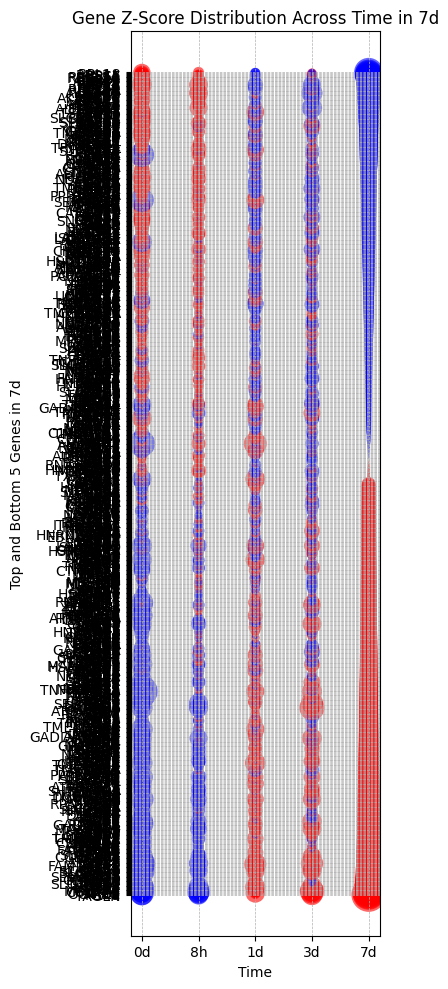

In [20]:
plot_dot_in_cat_rank2_and_save_csv(avg_zscores, "7d", target_len=1000,scale_factor=500)

Saved selected genes to /home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure//3d_selected_genes.csv


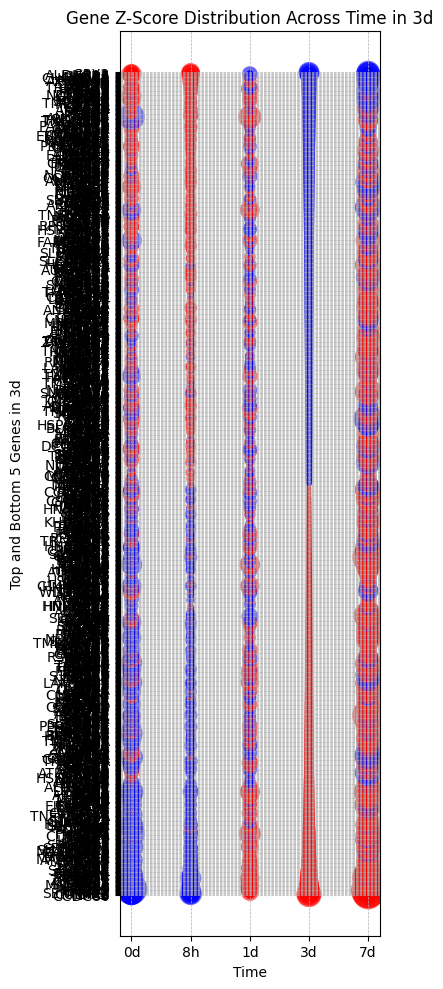

In [21]:
plot_dot_in_cat_rank2_and_save_csv(avg_zscores, "3d", target_len=1000,scale_factor=500)

Saved selected genes to /home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure//1d_selected_genes.csv


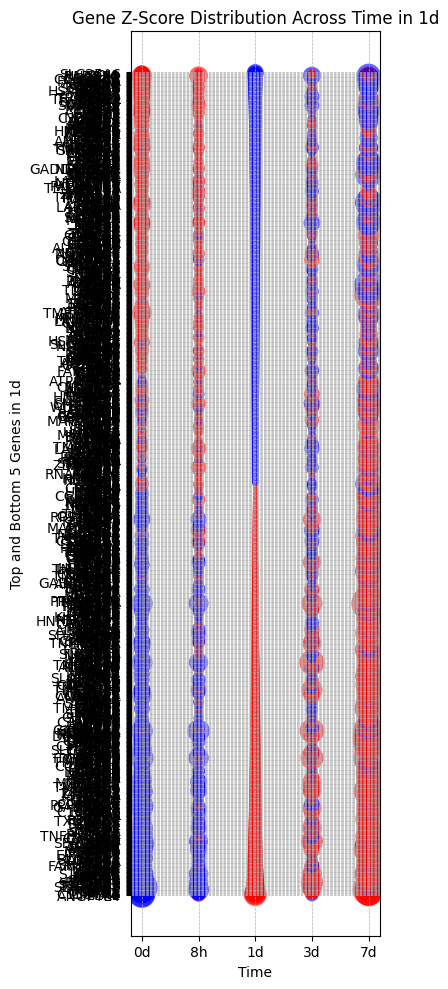

In [22]:
plot_dot_in_cat_rank2_and_save_csv(avg_zscores, "1d", target_len=1000,scale_factor=500)

Saved selected genes to /home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure//8h_selected_genes.csv


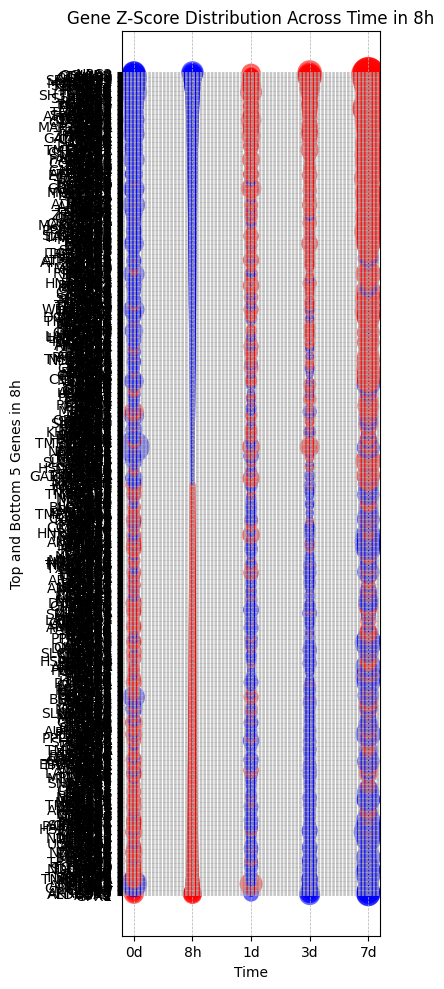

In [23]:
plot_dot_in_cat_rank2_and_save_csv(avg_zscores, "8h", target_len=1000,scale_factor=500)

Saved selected genes to /home/shi/WorkSpace/projects/scMultiNet_Data/Step_6_data/figure//0d_selected_genes.csv


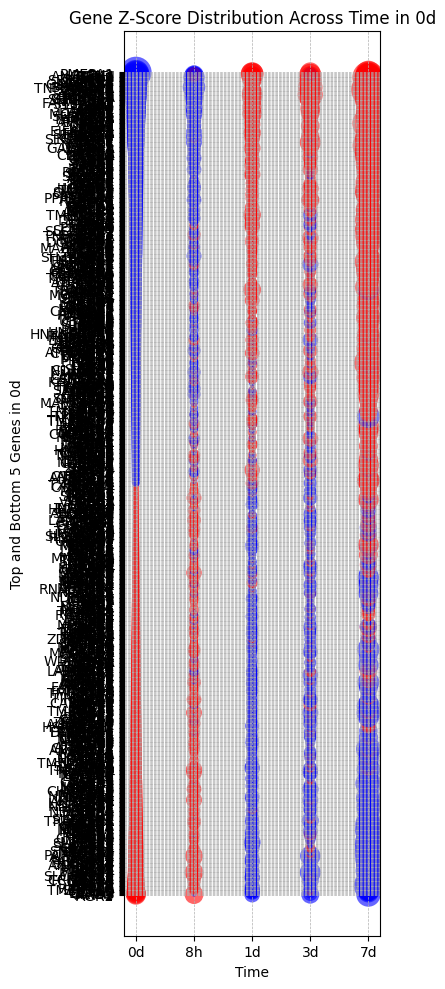

In [24]:
plot_dot_in_cat_rank2_and_save_csv(avg_zscores, "0d", target_len=1000,scale_factor=500)